In [28]:
from functools import partial

import torch
import torch.nn as nn
import torch.nn.functional as F

from models.nam import NAM
from models.dnn import DNN
from models.utils import *

from config.default import defaults

from trainer.trainer import Trainer
from trainer.raytrainer import *

from data.toydataset import ToyDataset
from data.generator import *

from typing import Sequence 
from typing import List

import matplotlib.pyplot as plt 
import numpy as np

import ray
from ray import tune, air
from ray.tune.schedulers import ASHAScheduler 
from ray.tune import CLIReporter


"""
@misc{kayid2020nams,
  title={Neural additive models Library},
  author={Kayid, Amr and Frosst, Nicholas and Hinton, Geoffrey E},
  year={2020}
}
"""

'\n@misc{kayid2020nams,\n  title={Neural additive models Library},\n  author={Kayid, Amr and Frosst, Nicholas and Hinton, Geoffrey E},\n  year={2020}\n}\n'

In [29]:
%reload_ext autoreload 
%autoreload 2

# Set up synthetic toy dataset 

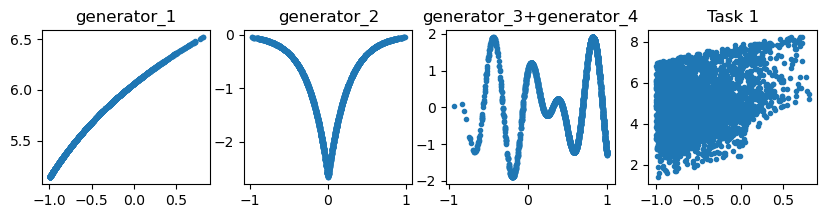

In [11]:
cfg = defaults()
gen_funcs, gen_func_names = task_1()

toydataset = ToyDataset(
    task_name="Task 1", 
    config=cfg, 
    num_samples=3000, 
    in_features=3, 
    x_start=-1, 
    x_end=1, 
    gen_funcs=gen_funcs, 
    gen_func_names=gen_func_names, 
    use_test=False,
)
toydataset.plot()

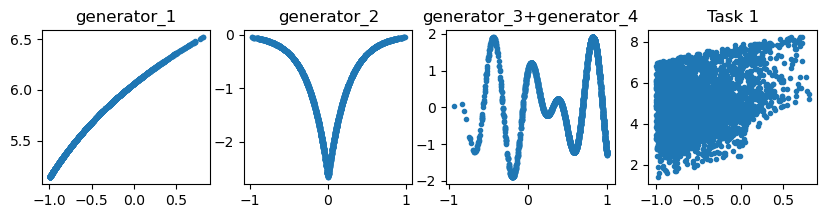

In [11]:
cfg = defaults()
gen_funcs, gen_func_names = task_1()

jaggedset = ToyDataset(
    task_name="Task 1", 
    config=cfg, 
    num_samples=3000, 
    in_features=3, 
    x_start=-1, 
    x_end=1, 
    gen_funcs=gen_funcs, 
    gen_func_names=gen_func_names, 
    use_test=False,
)
toydataset.plot()

10


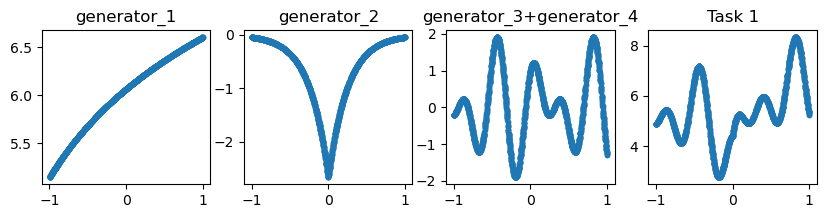

In [6]:
testdataset = ToyDataset(
    task_name="Task 1", 
    config=cfg, 
    num_samples=3000, 
    in_features=3, 
    x_start=-1, 
    x_end=1, 
    gen_funcs=gen_funcs, 
    gen_func_names=gen_func_names, 
    use_test=True,
)
testdataset.plot()
dataloader_train, dataloader_val, dataloader_test = testdataset.get_dataloaders()
print(len(dataloader_test))

# Hyper-parameter fine-tuning with ray.tune

In [5]:
#config = {
#    "lr": tune.loguniform(1e-3, 1e-1),
#    "decay_rate": tune.grid_search([*np.arange(0, 0.005, 0.001)])
#}
cfg.lr = tune.loguniform(1e-3, 1e-1) 

cfg.activation = tune.grid_search(['exu', 'relu'])

cfg.dropout = tune.grid_search([*np.arange(0, 1, 0.1), 0.05])
cfg.feature_dropout = tune.grid_search([*np.arange(0, 0.25, 0.05)])
cfg.l2_regularization=tune.loguniform(1e-6, 1e-4)
cfg.output_regularization=tune.loguniform(1e-3, 1e-1)
cfg.decay_rate = tune.choice([0, 0.005])
print(cfg)

Config(regression=True, use_dnn=False, num_epochs=200, batch_size=64, shuffle=True, early_stopping_patience=50, decay_rate=0.005, logdir='output', wandb=False, log_loss_frequency=2, lr=<ray.tune.search.sample.Float object at 0x2b8e743454e0>, l2_regularization=<ray.tune.search.sample.Float object at 0x2b8e7439bca0>, output_regularization=<ray.tune.search.sample.Float object at 0x2b8e74399600>, dropout={'grid_search': [0.0, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6000000000000001, 0.7000000000000001, 0.8, 0.9, 0.05]}, feature_dropout={'grid_search': [0.0, 0.05, 0.1, 0.15000000000000002, 0.2]}, num_basis_functions=64, hidden_sizes=[64, 32], activation={'grid_search': ['exu', 'relu']})


In [6]:
print(os.path.dirname(os.path.join(os.getcwd()))) 

/scratch/work/zhangx18/reproduced-nam


In [7]:
ray.shutdown()
ray.init(num_cpus=10, num_gpus=4)

metrics_name = "MAE" if cfg.regression else "Accuracy"
scheduler = ASHAScheduler(
        metric=metrics_name,
        mode="min",
    )

result = tune.run(
    partial(train, dataset=toydataset),
    config=vars(cfg),
    num_samples=10, # number of times to sample from the search sapce 
    scheduler=scheduler, 
    storage_path=os.path.join(cfg.logdir, "results"))

2023-06-30 16:26:03,802	INFO worker.py:1627 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 


Trial name,MAE,date,done,experiment_tag,hostname,iterations_since_restore,loss,node_ip,pid,time_since_restore,time_this_iter_s,time_total_s,timestamp,training_iteration,trial_id
train_b04a4_00000,0.633937,2023-06-30_16-28-31,True,"0_activation=exu,dropout=0.0000,feature_dropout=0.0000,l2_regularization=0.0001,lr=0.0281,output_regularization=0.0065",pe8.int.triton.aalto.fi,10,0.736005,10.10.100.8,24071,30.9768,3.23662,30.9768,1688131711,10,b04a4_00000
train_b04a4_00001,0.670595,2023-06-30_16-28-29,True,"1_activation=relu,dropout=0.0000,feature_dropout=0.0000,l2_regularization=0.0000,lr=0.0093,output_regularization=0.0993",pe8.int.triton.aalto.fi,10,0.972508,10.10.100.8,24072,29.2286,3.03689,29.2286,1688131709,10,b04a4_00001
train_b04a4_00002,1.25775,2023-06-30_16-28-03,True,,pe8.int.triton.aalto.fi,1,2.51334,10.10.100.8,24073,3.24261,3.24261,3.24261,1688131683,1,b04a4_00002
train_b04a4_00003,0.904209,2023-06-30_16-28-13,True,,pe8.int.triton.aalto.fi,4,1.22075,10.10.100.8,24074,13.1077,3.24034,13.1077,1688131693,4,b04a4_00003
train_b04a4_00004,1.10405,2023-06-30_16-28-04,True,,pe8.int.triton.aalto.fi,1,1.93169,10.10.100.8,24075,3.5755,3.5755,3.5755,1688131684,1,b04a4_00004
train_b04a4_00005,1.14956,2023-06-30_16-28-03,True,,pe8.int.triton.aalto.fi,1,2.06101,10.10.100.8,24076,3.25324,3.25324,3.25324,1688131683,1,b04a4_00005
train_b04a4_00006,1.24739,2023-06-30_16-28-04,True,,pe8.int.triton.aalto.fi,1,2.60711,10.10.100.8,24077,3.47588,3.47588,3.47588,1688131684,1,b04a4_00006
train_b04a4_00007,1.12557,2023-06-30_16-28-03,True,,pe8.int.triton.aalto.fi,1,2.01765,10.10.100.8,24078,3.14501,3.14501,3.14501,1688131683,1,b04a4_00007
train_b04a4_00008,1.64491,2023-06-30_16-28-04,True,,pe8.int.triton.aalto.fi,1,3.90542,10.10.100.8,24079,3.32338,3.32338,3.32338,1688131684,1,b04a4_00008
train_b04a4_00009,1.18959,2023-06-30_16-28-03,True,,pe8.int.triton.aalto.fi,1,2.25234,10.10.100.8,24080,3.12431,3.12431,3.12431,1688131683,1,b04a4_00009


(func pid=24072) epoch=1, loss_train: 3.642, metrics_train: 1.416
(func pid=24072) epoch=1, loss_val: 1.933, metrics_val: 1.050
(func pid=24072) epoch=3, loss_train: 1.749, metrics_train: 1.007 [repeated 17x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/ray-logging.html#log-deduplication for more options.)
(func pid=24072) epoch=3, loss_val: 1.698, metrics_val: 0.993 [repeated 17x across cluster]
(func pid=24072) epoch=5, loss_train: 1.577, metrics_train: 0.948 [repeated 13x across cluster]
(func pid=24072) epoch=5, loss_val: 1.507, metrics_val: 0.920 [repeated 13x across cluster]
(func pid=24074) epoch=1, loss_train: 23.810, metrics_train: 3.061 [repeated 9x across cluster]
(func pid=24074) epoch=1, loss_val: 2.367, metrics_val: 1.221 [repeated 9x across cluster]
(func pid=24072) epoch=9, loss_train: 1.117, metrics_train: 0.766 [repeated 12x across cluster]
(func pid=24072) e

2023-06-30 16:33:50,562	WARNING util.py:315 -- The `callbacks.on_trial_result` operation took 0.599 s, which may be a performance bottleneck.
2023-06-30 16:33:50,565	WARNING util.py:315 -- The `process_trial_result` operation took 0.602 s, which may be a performance bottleneck.
2023-06-30 16:33:50,567	WARNING util.py:315 -- Processing trial results took 0.604 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2023-06-30 16:33:50,569	WARNING util.py:315 -- The `process_trial_result` operation took 0.607 s, which may be a performance bottleneck.


(func pid=24075) epoch=1, loss_train: 8.209, metrics_train: 2.275 [repeated 13x across cluster]
(func pid=24075) epoch=1, loss_val: 2.643, metrics_val: 1.260 [repeated 13x across cluster]
(func pid=24072) epoch=1, loss_train: 10.667, metrics_train: 2.459 [repeated 13x across cluster]
(func pid=24072) epoch=1, loss_val: 1.650, metrics_val: 1.038 [repeated 13x across cluster]
(func pid=24072) epoch=3, loss_train: 3.426, metrics_train: 1.476 [repeated 11x across cluster]
(func pid=24072) epoch=3, loss_val: 1.909, metrics_val: 1.109 [repeated 11x across cluster]
(func pid=24073) epoch=1, loss_train: 9.093, metrics_train: 1.929 [repeated 11x across cluster]
(func pid=24073) epoch=1, loss_val: 1.453, metrics_val: 0.960 [repeated 11x across cluster]
(func pid=24077) Finished Training.
(func pid=24077) epoch=1, loss_train: 3.644, metrics_train: 1.494 [repeated 11x across cluster]
(func pid=24077) epoch=1, loss_val: 1.534, metrics_val: 1.014 [repeated 11x across cluster]
(func pid=24073) epoch=

2023-06-30 16:37:48,321	WARNING util.py:315 -- The `callbacks.on_trial_result` operation took 0.771 s, which may be a performance bottleneck.
2023-06-30 16:37:48,323	WARNING util.py:315 -- The `process_trial_result` operation took 0.774 s, which may be a performance bottleneck.
2023-06-30 16:37:48,324	WARNING util.py:315 -- Processing trial results took 0.775 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2023-06-30 16:37:48,324	WARNING util.py:315 -- The `process_trial_result` operation took 0.776 s, which may be a performance bottleneck.


(func pid=24079) epoch=1, loss_train: 368.469, metrics_train: 7.552 [repeated 13x across cluster]
(func pid=24079) epoch=1, loss_val: 21.425, metrics_val: 4.438 [repeated 13x across cluster]
(func pid=24073) epoch=1, loss_train: 32.594, metrics_train: 4.718 [repeated 11x across cluster]
(func pid=24073) epoch=1, loss_val: 16.696, metrics_val: 3.875 [repeated 11x across cluster]
(func pid=24077) epoch=3, loss_train: 4.693, metrics_train: 1.713 [repeated 14x across cluster]
(func pid=24077) epoch=3, loss_val: 2.185, metrics_val: 1.152 [repeated 14x across cluster]
(func pid=24073) epoch=3, loss_train: 1.537, metrics_train: 1.017 [repeated 4x across cluster]
(func pid=24073) epoch=3, loss_val: 1.453, metrics_val: 0.991 [repeated 4x across cluster]
(func pid=24075) epoch=1, loss_train: 20.296, metrics_train: 2.763 [repeated 15x across cluster]
(func pid=24075) epoch=1, loss_val: 1.329, metrics_val: 0.961 [repeated 15x across cluster]
(func pid=24073) epoch=1, loss_train: 4.103, metrics_tra

2023-06-30 16:39:13,736	WARNING util.py:315 -- The `callbacks.on_trial_result` operation took 0.742 s, which may be a performance bottleneck.
2023-06-30 16:39:13,738	WARNING util.py:315 -- The `process_trial_result` operation took 0.745 s, which may be a performance bottleneck.
2023-06-30 16:39:13,738	WARNING util.py:315 -- Processing trial results took 0.745 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2023-06-30 16:39:13,739	WARNING util.py:315 -- The `process_trial_result` operation took 0.746 s, which may be a performance bottleneck.


(func pid=24080) epoch=1, loss_train: 273.654, metrics_train: 7.243 [repeated 10x across cluster]
(func pid=24080) epoch=1, loss_val: 7.117, metrics_val: 2.342 [repeated 10x across cluster]
(func pid=24072) epoch=1, loss_train: 79.897, metrics_train: 5.693 [repeated 12x across cluster]
(func pid=24072) epoch=1, loss_val: 17.415, metrics_val: 3.963 [repeated 12x across cluster]
(func pid=24080) epoch=1, loss_train: 21.771, metrics_train: 4.131 [repeated 12x across cluster]
(func pid=24080) epoch=1, loss_val: 14.596, metrics_val: 3.591 [repeated 12x across cluster]
(func pid=24071) Finished Training.
(func pid=24071) epoch=1, loss_train: 5.991, metrics_train: 1.929 [repeated 10x across cluster]
(func pid=24071) epoch=1, loss_val: 2.336, metrics_val: 1.215 [repeated 10x across cluster]


2023-06-30 16:39:35,885	WARNING util.py:315 -- The `callbacks.on_trial_result` operation took 0.529 s, which may be a performance bottleneck.
2023-06-30 16:39:35,888	WARNING util.py:315 -- The `process_trial_result` operation took 0.532 s, which may be a performance bottleneck.
2023-06-30 16:39:35,890	WARNING util.py:315 -- Processing trial results took 0.535 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2023-06-30 16:39:35,891	WARNING util.py:315 -- The `process_trial_result` operation took 0.536 s, which may be a performance bottleneck.


(func pid=24075) epoch=3, loss_train: 1.194, metrics_train: 0.861 [repeated 12x across cluster]
(func pid=24075) epoch=3, loss_val: 1.195, metrics_val: 0.884 [repeated 12x across cluster]
(func pid=24073) Finished Training.
(func pid=24079) epoch=1, loss_train: 4.227, metrics_train: 1.624 [repeated 11x across cluster]
(func pid=24079) epoch=1, loss_val: 2.143, metrics_val: 1.179 [repeated 11x across cluster]
(func pid=24074) Finished Training.
(func pid=24079) epoch=1, loss_train: 9.091, metrics_train: 2.459 [repeated 10x across cluster]
(func pid=24079) epoch=1, loss_val: 4.060, metrics_val: 1.667 [repeated 10x across cluster]
(func pid=24075) epoch=9, loss_train: 0.956, metrics_train: 0.761 [repeated 11x across cluster]
(func pid=24075) epoch=9, loss_val: 0.931, metrics_val: 0.770 [repeated 11x across cluster]
(func pid=24072) epoch=3, loss_train: 2.328, metrics_train: 1.194 [repeated 9x across cluster]
(func pid=24072) epoch=3, loss_val: 0.849, metrics_val: 0.772 [repeated 9x across

2023-06-30 16:40:03,961	WARNING util.py:315 -- The `callbacks.on_trial_result` operation took 0.502 s, which may be a performance bottleneck.
2023-06-30 16:40:03,963	WARNING util.py:315 -- The `process_trial_result` operation took 0.505 s, which may be a performance bottleneck.
2023-06-30 16:40:03,964	WARNING util.py:315 -- Processing trial results took 0.506 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2023-06-30 16:40:03,965	WARNING util.py:315 -- The `process_trial_result` operation took 0.507 s, which may be a performance bottleneck.


(func pid=24080) epoch=1, loss_train: 8.492, metrics_train: 2.314 [repeated 6x across cluster]
(func pid=24080) epoch=1, loss_val: 2.455, metrics_val: 1.250 [repeated 6x across cluster]


2023-06-30 16:40:07,351	WARNING util.py:315 -- The `callbacks.on_trial_result` operation took 0.502 s, which may be a performance bottleneck.
2023-06-30 16:40:07,352	WARNING util.py:315 -- The `process_trial_result` operation took 0.503 s, which may be a performance bottleneck.
2023-06-30 16:40:07,353	WARNING util.py:315 -- Processing trial results took 0.505 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2023-06-30 16:40:07,354	WARNING util.py:315 -- The `process_trial_result` operation took 0.506 s, which may be a performance bottleneck.


(func pid=24073) epoch=3, loss_train: 2.424, metrics_train: 1.185 [repeated 9x across cluster]
(func pid=24073) epoch=3, loss_val: 1.447, metrics_val: 0.938 [repeated 9x across cluster]


2023-06-30 16:40:12,985	WARNING util.py:315 -- The `callbacks.on_trial_result` operation took 0.515 s, which may be a performance bottleneck.
2023-06-30 16:40:12,988	WARNING util.py:315 -- The `process_trial_result` operation took 0.518 s, which may be a performance bottleneck.
2023-06-30 16:40:12,989	WARNING util.py:315 -- Processing trial results took 0.519 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2023-06-30 16:40:12,989	WARNING util.py:315 -- The `process_trial_result` operation took 0.520 s, which may be a performance bottleneck.
2023-06-30 16:40:13,542	WARNING util.py:315 -- The `callbacks.on_trial_result` operation took 0.503 s, which may be a performance bottleneck.
2023-06-30 16:40:13,544	WARNING util.py:315 -- The `process_trial_result` operation took 0.506 s, which may be a performance bottleneck.
2023-06-30 16:40:13,545	WARNING util.py:315 -- Processing trial results took 0.506 s, which may be a performance bott

(func pid=24079) Finished Training.
(func pid=24075) epoch=3, loss_train: 2.603, metrics_train: 1.265 [repeated 8x across cluster]
(func pid=24075) epoch=3, loss_val: 0.654, metrics_val: 0.646 [repeated 8x across cluster]
(func pid=24078) epoch=1, loss_val: 7.181, metrics_val: 2.342
(func pid=24071) epoch=3, loss_train: 2.238, metrics_train: 1.176 [repeated 12x across cluster]
(func pid=24071) epoch=3, loss_val: 1.054, metrics_val: 0.860 [repeated 12x across cluster]


2023-06-30 16:40:22,623	WARNING util.py:315 -- The `process_trial_result` operation took 0.501 s, which may be a performance bottleneck.
2023-06-30 16:40:22,626	WARNING util.py:315 -- Processing trial results took 0.503 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2023-06-30 16:40:22,627	WARNING util.py:315 -- The `process_trial_result` operation took 0.505 s, which may be a performance bottleneck.
2023-06-30 16:40:26,916	WARNING util.py:315 -- The `callbacks.on_trial_result` operation took 0.502 s, which may be a performance bottleneck.
2023-06-30 16:40:26,921	WARNING util.py:315 -- The `process_trial_result` operation took 0.508 s, which may be a performance bottleneck.
2023-06-30 16:40:26,922	WARNING util.py:315 -- Processing trial results took 0.508 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2023-06-30 16:40:26,922	WARNING util.py:315 -- The `process_trial_resul

(func pid=24073) epoch=1, loss_train: 93.577, metrics_train: 6.214 [repeated 4x across cluster]
(func pid=24073) epoch=1, loss_val: 21.427, metrics_val: 4.441 [repeated 4x across cluster]


2023-06-30 16:40:28,973	WARNING util.py:315 -- The `callbacks.on_trial_result` operation took 0.502 s, which may be a performance bottleneck.
2023-06-30 16:40:28,975	WARNING util.py:315 -- The `process_trial_result` operation took 0.505 s, which may be a performance bottleneck.
2023-06-30 16:40:28,976	WARNING util.py:315 -- Processing trial results took 0.506 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2023-06-30 16:40:28,977	WARNING util.py:315 -- The `process_trial_result` operation took 0.507 s, which may be a performance bottleneck.


(func pid=24072) epoch=9, loss_train: 1.024, metrics_train: 0.787 [repeated 9x across cluster]
(func pid=24072) epoch=9, loss_val: 0.494, metrics_val: 0.572 [repeated 9x across cluster]
(func pid=24075) Finished Training.


2023-06-30 16:40:35,051	WARNING util.py:315 -- The `callbacks.on_trial_result` operation took 0.518 s, which may be a performance bottleneck.
2023-06-30 16:40:35,053	WARNING util.py:315 -- The `process_trial_result` operation took 0.520 s, which may be a performance bottleneck.
2023-06-30 16:40:35,054	WARNING util.py:315 -- Processing trial results took 0.521 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2023-06-30 16:40:35,056	WARNING util.py:315 -- The `process_trial_result` operation took 0.523 s, which may be a performance bottleneck.
2023-06-30 16:40:36,332	WARNING util.py:315 -- The `callbacks.on_trial_result` operation took 0.808 s, which may be a performance bottleneck.
2023-06-30 16:40:36,339	WARNING util.py:315 -- The `process_trial_result` operation took 0.816 s, which may be a performance bottleneck.
2023-06-30 16:40:36,340	WARNING util.py:315 -- Processing trial results took 0.817 s, which may be a performance bott

(func pid=24074) epoch=1, loss_train: 11.809, metrics_train: 2.626 [repeated 10x across cluster]
(func pid=24074) epoch=1, loss_val: 2.496, metrics_val: 1.269 [repeated 10x across cluster]
(func pid=24072) epoch=1, loss_val: 2.496, metrics_val: 1.269


2023-06-30 16:40:41,235	WARNING util.py:315 -- The `callbacks.on_trial_result` operation took 0.501 s, which may be a performance bottleneck.
2023-06-30 16:40:41,240	WARNING util.py:315 -- The `process_trial_result` operation took 0.507 s, which may be a performance bottleneck.
2023-06-30 16:40:41,241	WARNING util.py:315 -- Processing trial results took 0.508 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2023-06-30 16:40:41,241	WARNING util.py:315 -- The `process_trial_result` operation took 0.509 s, which may be a performance bottleneck.


(func pid=24075) epoch=1, loss_train: 13.734, metrics_train: 3.156 [repeated 4x across cluster]
(func pid=24075) epoch=1, loss_val: 5.952, metrics_val: 2.097 [repeated 4x across cluster]


2023-06-30 16:40:45,881	WARNING util.py:315 -- The `callbacks.on_trial_result` operation took 0.516 s, which may be a performance bottleneck.
2023-06-30 16:40:45,883	WARNING util.py:315 -- The `process_trial_result` operation took 0.518 s, which may be a performance bottleneck.
2023-06-30 16:40:45,884	WARNING util.py:315 -- Processing trial results took 0.519 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2023-06-30 16:40:45,884	WARNING util.py:315 -- The `process_trial_result` operation took 0.520 s, which may be a performance bottleneck.


(func pid=24076) epoch=1, loss_train: 7.806, metrics_train: 2.245 [repeated 12x across cluster]
(func pid=24076) epoch=1, loss_val: 2.480, metrics_val: 1.278 [repeated 12x across cluster]
(func pid=24071) Finished Training.


2023-06-30 16:40:53,495	WARNING util.py:315 -- The `callbacks.on_trial_result` operation took 0.510 s, which may be a performance bottleneck.
2023-06-30 16:40:53,497	WARNING util.py:315 -- The `process_trial_result` operation took 0.513 s, which may be a performance bottleneck.
2023-06-30 16:40:53,498	WARNING util.py:315 -- Processing trial results took 0.514 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2023-06-30 16:40:53,498	WARNING util.py:315 -- The `process_trial_result` operation took 0.515 s, which may be a performance bottleneck.
2023-06-30 16:40:54,019	WARNING util.py:315 -- The `callbacks.on_trial_result` operation took 0.509 s, which may be a performance bottleneck.
2023-06-30 16:40:54,020	WARNING util.py:315 -- The `process_trial_result` operation took 0.511 s, which may be a performance bottleneck.
2023-06-30 16:40:54,021	WARNING util.py:315 -- Processing trial results took 0.512 s, which may be a performance bott

(func pid=24071) epoch=1, loss_train: 281.435, metrics_train: 6.508 [repeated 11x across cluster]
(func pid=24071) epoch=1, loss_val: 4.611, metrics_val: 1.783 [repeated 11x across cluster]
(func pid=24079) epoch=5, loss_train: 1.934, metrics_train: 1.086 [repeated 5x across cluster]
(func pid=24079) epoch=5, loss_val: 0.875, metrics_val: 0.775 [repeated 5x across cluster]
(func pid=24079) Finished Training.


2023-06-30 16:41:05,702	INFO tune.py:1111 -- Total run time: 890.43 seconds (890.10 seconds for the tuning loop).


In [8]:
best_trial = result.get_best_trial(metric=metrics_name, mode="min", scope="last")
print(f"Best trial config: {best_trial.config}")
print(f"Best trial final validation loss: {best_trial.last_result['loss']}")
print(f"Best trial final validation metric: {best_trial.last_result[metrics_name]}")

Best trial config: {'regression': True, 'use_dnn': False, 'num_epochs': 200, 'batch_size': 64, 'shuffle': True, 'early_stopping_patience': 50, 'decay_rate': 0.005, 'logdir': 'output', 'wandb': False, 'log_loss_frequency': 2, 'lr': 0.03661886602093255, 'l2_regularization': 3.6062562642844017e-06, 'output_regularization': 0.0013779426908964282, 'dropout': 0.0, 'feature_dropout': 0.0, 'num_basis_functions': 64, 'hidden_sizes': [64, 32], 'activation': 'relu'}
Best trial final validation loss: 0.3253616392612457
Best trial final validation metric: 0.3871640801429749


In [9]:
cfg.update(**best_trial.config)
print(cfg)

Config(regression=True, use_dnn=False, num_epochs=200, batch_size=64, shuffle=True, early_stopping_patience=50, decay_rate=0.005, logdir='output', wandb=False, log_loss_frequency=2, lr=0.03661886602093255, l2_regularization=3.6062562642844017e-06, output_regularization=0.0013779426908964282, dropout=0.0, feature_dropout=0.0, num_basis_functions=64, hidden_sizes=[64, 32], activation='relu')


NAM(
  (feature_dropout): Dropout(p=0.0, inplace=False)
  (feature_nns): ModuleList(
    (0-2): 3 x FeatureNN(
      (model): Sequential(
        (0): LinearReLU(in_features=1, out_features=64)
        (1): Dropout(p=0.0, inplace=False)
        (2): LinearReLU(in_features=64, out_features=64)
        (3): Dropout(p=0.0, inplace=False)
        (4): LinearReLU(in_features=64, out_features=32)
        (5): Dropout(p=0.0, inplace=False)
        (6): Linear(in_features=32, out_features=1, bias=True)
        (7): Dropout(p=0.0, inplace=False)
      )
    )
  )
)
loss_train_epoch: 2.8765482902526855, MAE_train_epoch: 1.2577082460576838
loss_val_epoch: 1.2154289484024048, MAE_val_epoch: 0.9191891193389893
loss_train_epoch: 1.111055850982666, MAE_train_epoch: 0.8741115114905618
loss_val_epoch: 1.1566015481948853, MAE_val_epoch: 0.8990757703781128
loss_train_epoch: 0.9216499924659729, MAE_train_epoch: 0.7947514328089628
loss_val_epoch: 0.8311723470687866, MAE_val_epoch: 0.7520585060119629
loss_t

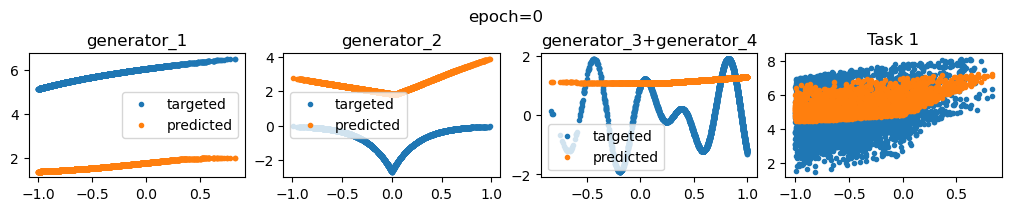

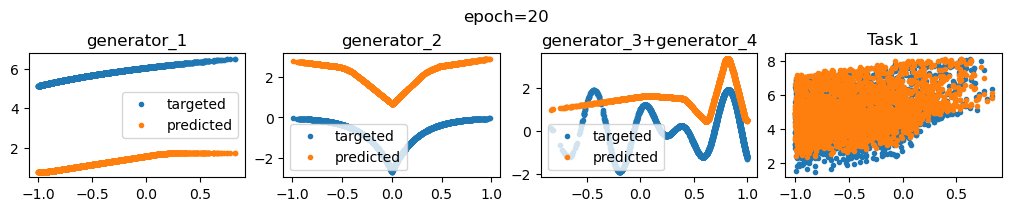

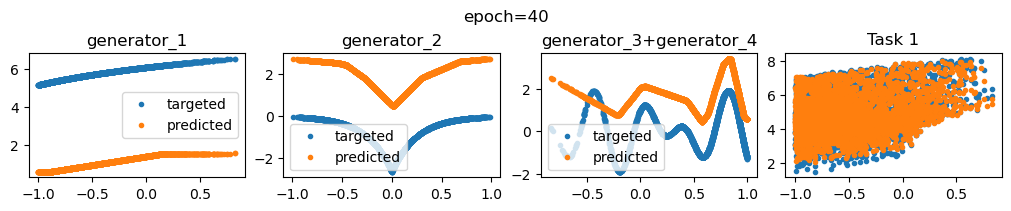

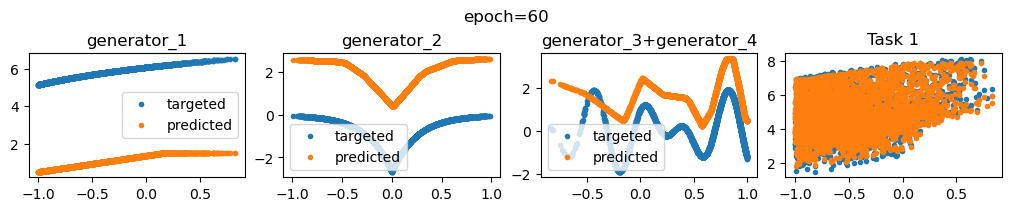

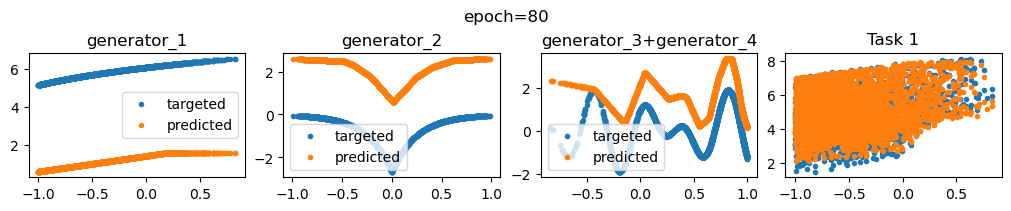

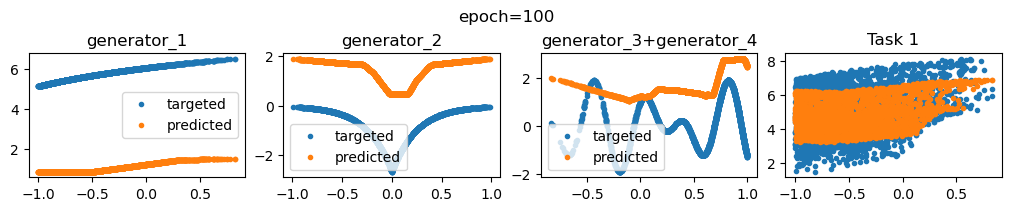

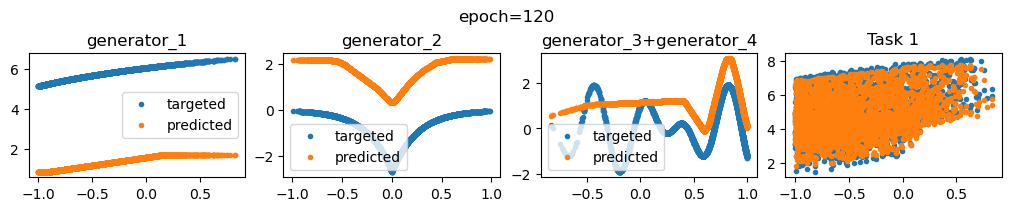

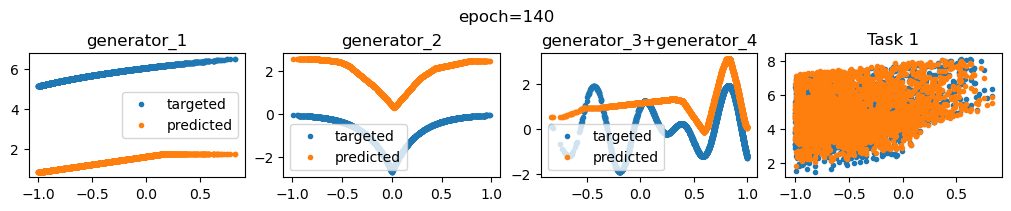

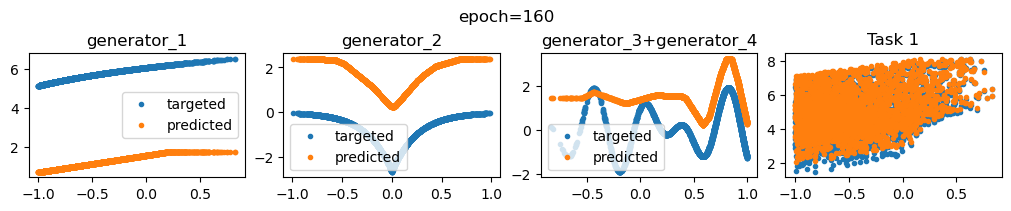

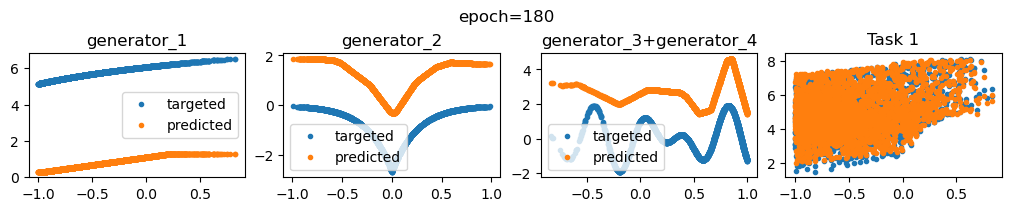

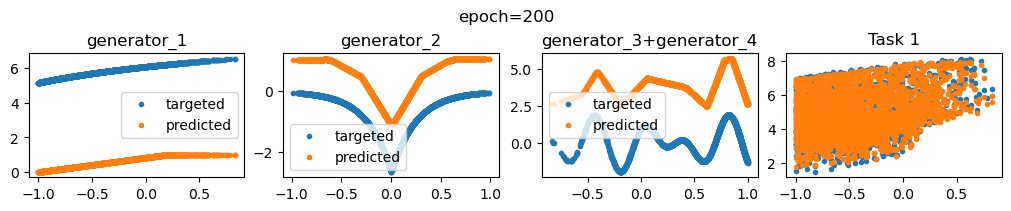

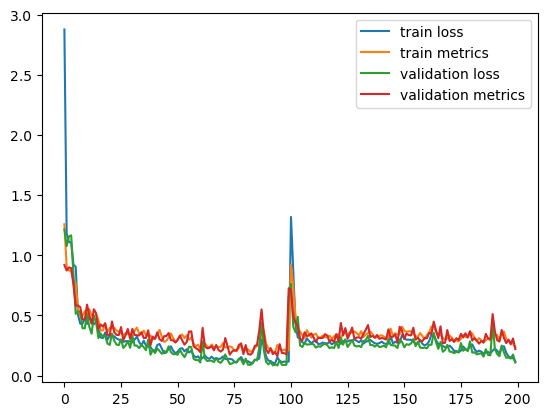

In [10]:
cfg.num_epochs = 200
cfg.log_loss_frequency = 2
best_trained_model = NAM(config=cfg, 
                         name="NAM_FINE_TUNE", 
                         in_features=len(toydataset[0][0]), 
                         num_units=cfg.num_basis_functions)

print(best_trained_model)
trainer = Trainer(cfg, best_trained_model, toydataset)   
losses_train, metricses_train, losses_val, metricses_val = trainer.train()

#best_checkpoint = best_trial.checkpoint.to_air_checkpoint()
#best_checkpoint_data = best_checkpoint.to_dict()

#best_trained_model.load_state_dict(best_checkpoint_data["model_state_dict"])


# Trainer Sample

In [30]:
cfg = Config(regression=True, use_dnn=False, num_epochs=200, batch_size=64, shuffle=True, early_stopping_patience=50, decay_rate=0.005, logdir='output', wandb=False, log_loss_frequency=2, lr=0.03661886602093255, l2_regularization=3.6062562642844017e-06, output_regularization=0.0013779426908964282, dropout=0.0, feature_dropout=0.0, num_basis_functions=64, hidden_sizes=[64, 32], activation='relu')
cfg.num_epochs=100
nam_relu = NAM(
    config=cfg, 
    name="NAM Model", 
    in_features=len(toydataset[0][0]), 
    num_units=cfg.num_basis_functions)
print(nam_relu)
trainer_relu = Trainer(cfg, nam_relu, toydataset)   
print(cfg)

NAM(
  (feature_dropout): Dropout(p=0.0, inplace=False)
  (feature_nns): ModuleList(
    (0-2): 3 x FeatureNN(
      (model): Sequential(
        (0): LinearReLU(in_features=1, out_features=64)
        (1): Dropout(p=0.0, inplace=False)
        (2): LinearReLU(in_features=64, out_features=64)
        (3): Dropout(p=0.0, inplace=False)
        (4): LinearReLU(in_features=64, out_features=32)
        (5): Dropout(p=0.0, inplace=False)
        (6): Linear(in_features=32, out_features=1, bias=True)
        (7): Dropout(p=0.0, inplace=False)
      )
    )
  )
)
Config(regression=True, use_dnn=False, num_epochs=100, batch_size=64, shuffle=True, early_stopping_patience=50, decay_rate=0.005, logdir='output', wandb=False, log_loss_frequency=2, lr=0.03661886602093255, l2_regularization=3.6062562642844017e-06, output_regularization=0.0013779426908964282, dropout=0.0, feature_dropout=0.0, num_basis_functions=64, hidden_sizes=[64, 32], activation='relu')


loss_train_epoch: 5.381716251373291, MAE_train_epoch: 1.6408377958066536
loss_val_epoch: 1.3499876260757446, MAE_val_epoch: 0.9595035672187805
loss_train_epoch: 1.0721044540405273, MAE_train_epoch: 0.8582875060312676
loss_val_epoch: 1.1007442474365234, MAE_val_epoch: 0.8768962979316711
loss_train_epoch: 1.072587013244629, MAE_train_epoch: 0.8564589294520292
loss_val_epoch: 1.2930361032485962, MAE_val_epoch: 0.9496553540229797
loss_train_epoch: 1.0246672630310059, MAE_train_epoch: 0.8379178661288638
loss_val_epoch: 1.1018197536468506, MAE_val_epoch: 0.8770102858543396
loss_train_epoch: 0.9660179615020752, MAE_train_epoch: 0.8107552311637185
loss_val_epoch: 1.0524250268936157, MAE_val_epoch: 0.8609977722167969
loss_train_epoch: 0.9357054233551025, MAE_train_epoch: 0.801900894352884
loss_val_epoch: 0.966619610786438, MAE_val_epoch: 0.8276111245155334
loss_train_epoch: 0.6288246512413025, MAE_train_epoch: 0.6274802991838166
loss_val_epoch: 0.44611161947250366, MAE_val_epoch: 0.528057277202

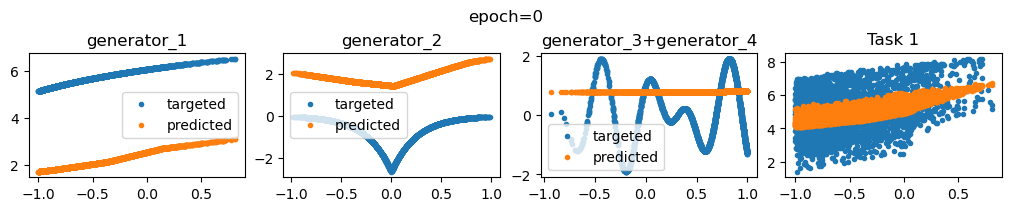

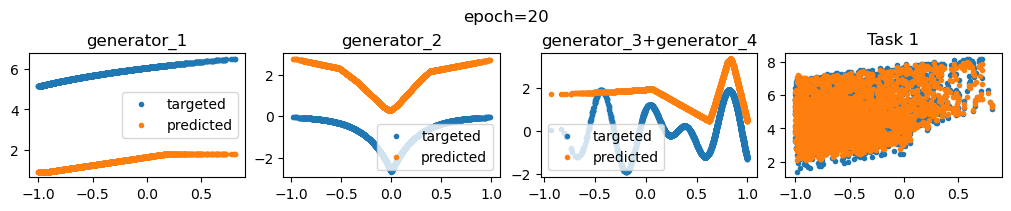

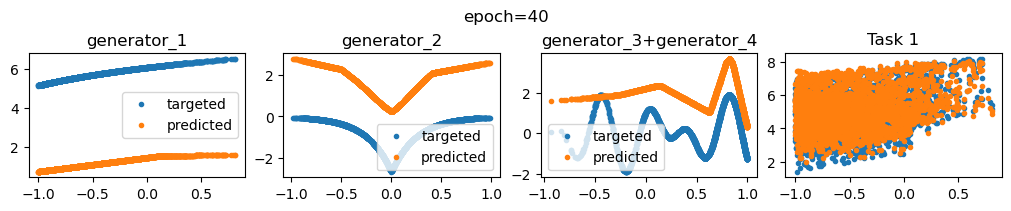

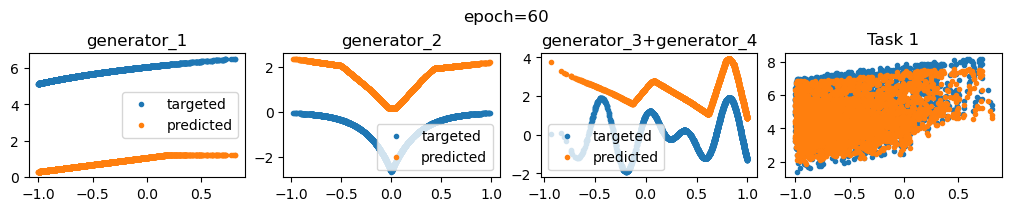

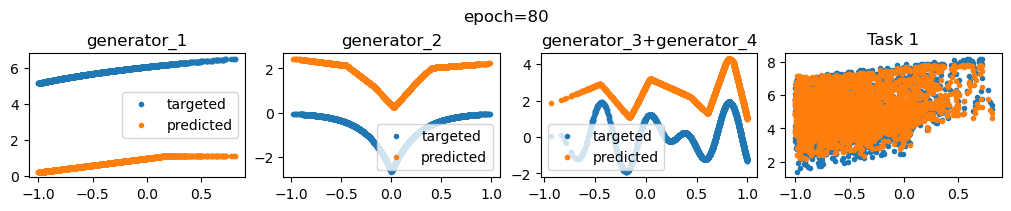

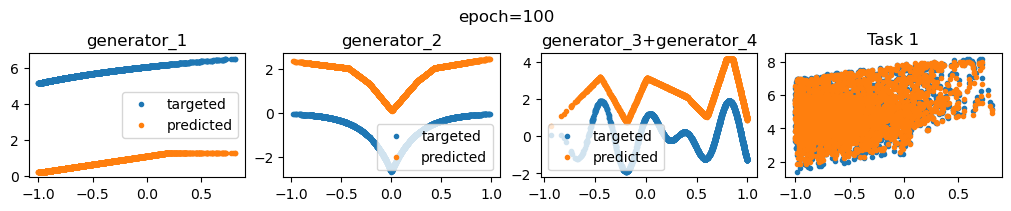

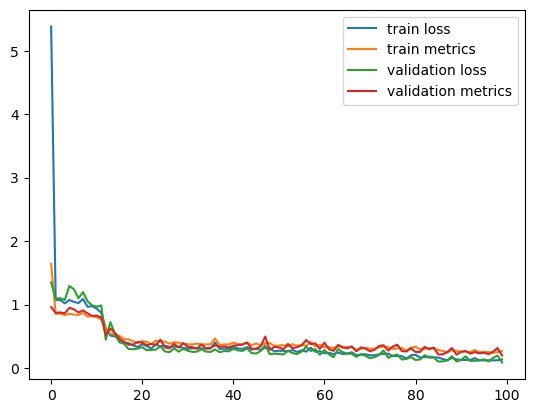

In [31]:
losses_train, metricses_train, losses_val, metricses_val = trainer_relu.train()

In [20]:
best_config = Config(regression=True, use_dnn=False, num_epochs=100, batch_size=64, shuffle=True, early_stopping_patience=50, decay_rate=0.005, logdir='output', wandb=False, log_loss_frequency=20, lr=0.0628293015410041, l2_regularization=1.9437325458482763e-06, output_regularization=0.00521113869949085, dropout=0.0, feature_dropout=0.0, num_basis_functions=64, hidden_sizes=[64, 32], activation='relu')

In [23]:
best_config.log_loss_frequency = 2
best_model = NAM(
    config=best_config, 
    name="NAM Model", 
    in_features=len(toydataset[0][0]), 
    num_units=best_config.num_basis_functions)
print(best_model)
best_trainer = Trainer(best_config, best_model, toydataset)   

NAM(
  (feature_dropout): Dropout(p=0.0, inplace=False)
  (feature_nns): ModuleList(
    (0-2): 3 x FeatureNN(
      (model): Sequential(
        (0): LinearReLU(in_features=1, out_features=64)
        (1): Dropout(p=0.0, inplace=False)
        (2): LinearReLU(in_features=64, out_features=64)
        (3): Dropout(p=0.0, inplace=False)
        (4): LinearReLU(in_features=64, out_features=32)
        (5): Dropout(p=0.0, inplace=False)
        (6): Linear(in_features=32, out_features=1, bias=True)
        (7): Dropout(p=0.0, inplace=False)
      )
    )
  )
)


loss_train_epoch: 11.456050872802734, MAE_train_epoch: 2.265582120779789
loss_val_epoch: 1.6496623754501343, MAE_val_epoch: 1.053240919113159
loss_train_epoch: 1.1197038888931274, MAE_train_epoch: 0.8547511913559653
loss_val_epoch: 0.9386674761772156, MAE_val_epoch: 0.7768725395202637
loss_train_epoch: 1.0278005599975586, MAE_train_epoch: 0.8321905641844778
loss_val_epoch: 1.058738350868225, MAE_val_epoch: 0.8244799852371216
loss_train_epoch: 1.0381920337677002, MAE_train_epoch: 0.8308702743414677
loss_val_epoch: 0.9682750701904297, MAE_val_epoch: 0.8011899828910828
loss_train_epoch: 1.0146572589874268, MAE_train_epoch: 0.819505821574818
loss_val_epoch: 1.0092666149139404, MAE_val_epoch: 0.8031581997871399
loss_train_epoch: 0.8650985360145569, MAE_train_epoch: 0.7500108209523287
loss_val_epoch: 0.643524169921875, MAE_val_epoch: 0.6426613211631775
loss_train_epoch: 0.6361093521118164, MAE_train_epoch: 0.6361211917617104
loss_val_epoch: 0.6061774492263794, MAE_val_epoch: 0.56745554208755

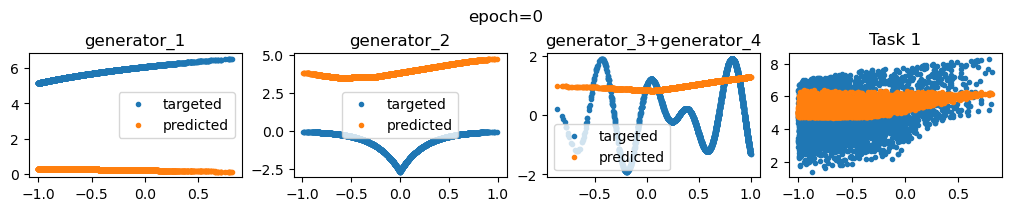

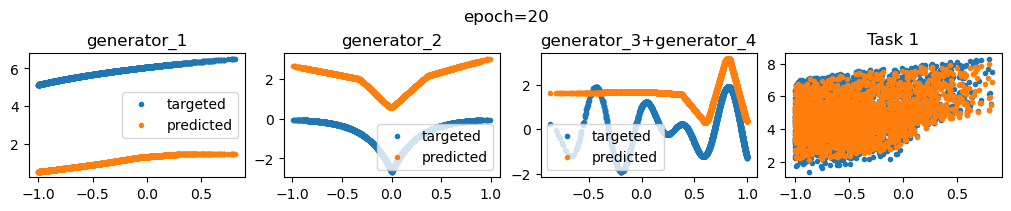

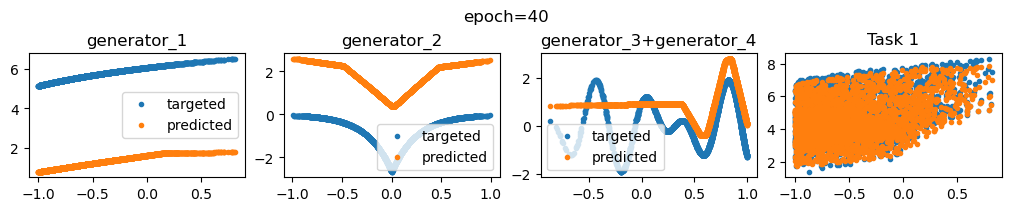

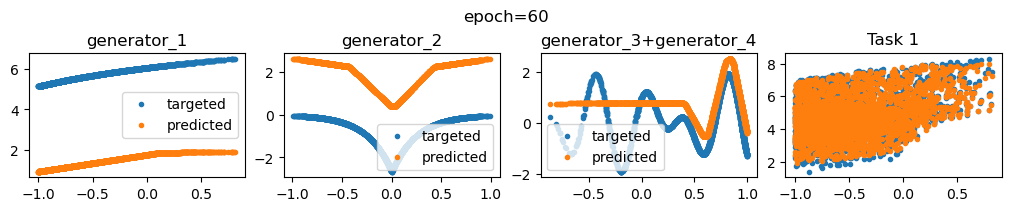

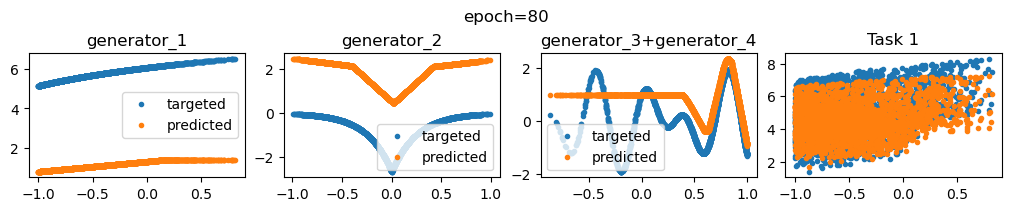

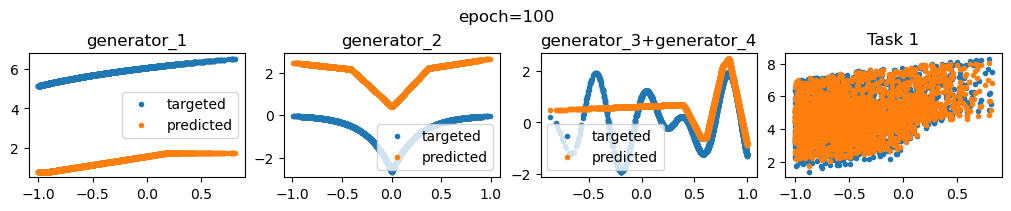

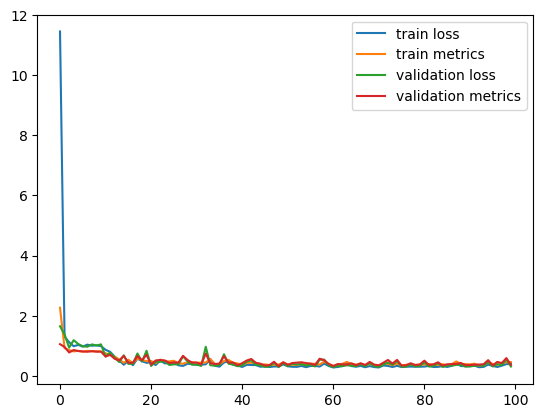

In [24]:
losses_train, metricses_train, losses_val, metricses_val = best_trainer.train()